In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import glob
import seaborn as sns
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image


In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
cd train

c:\Users\AI06\Desktop\DL\train


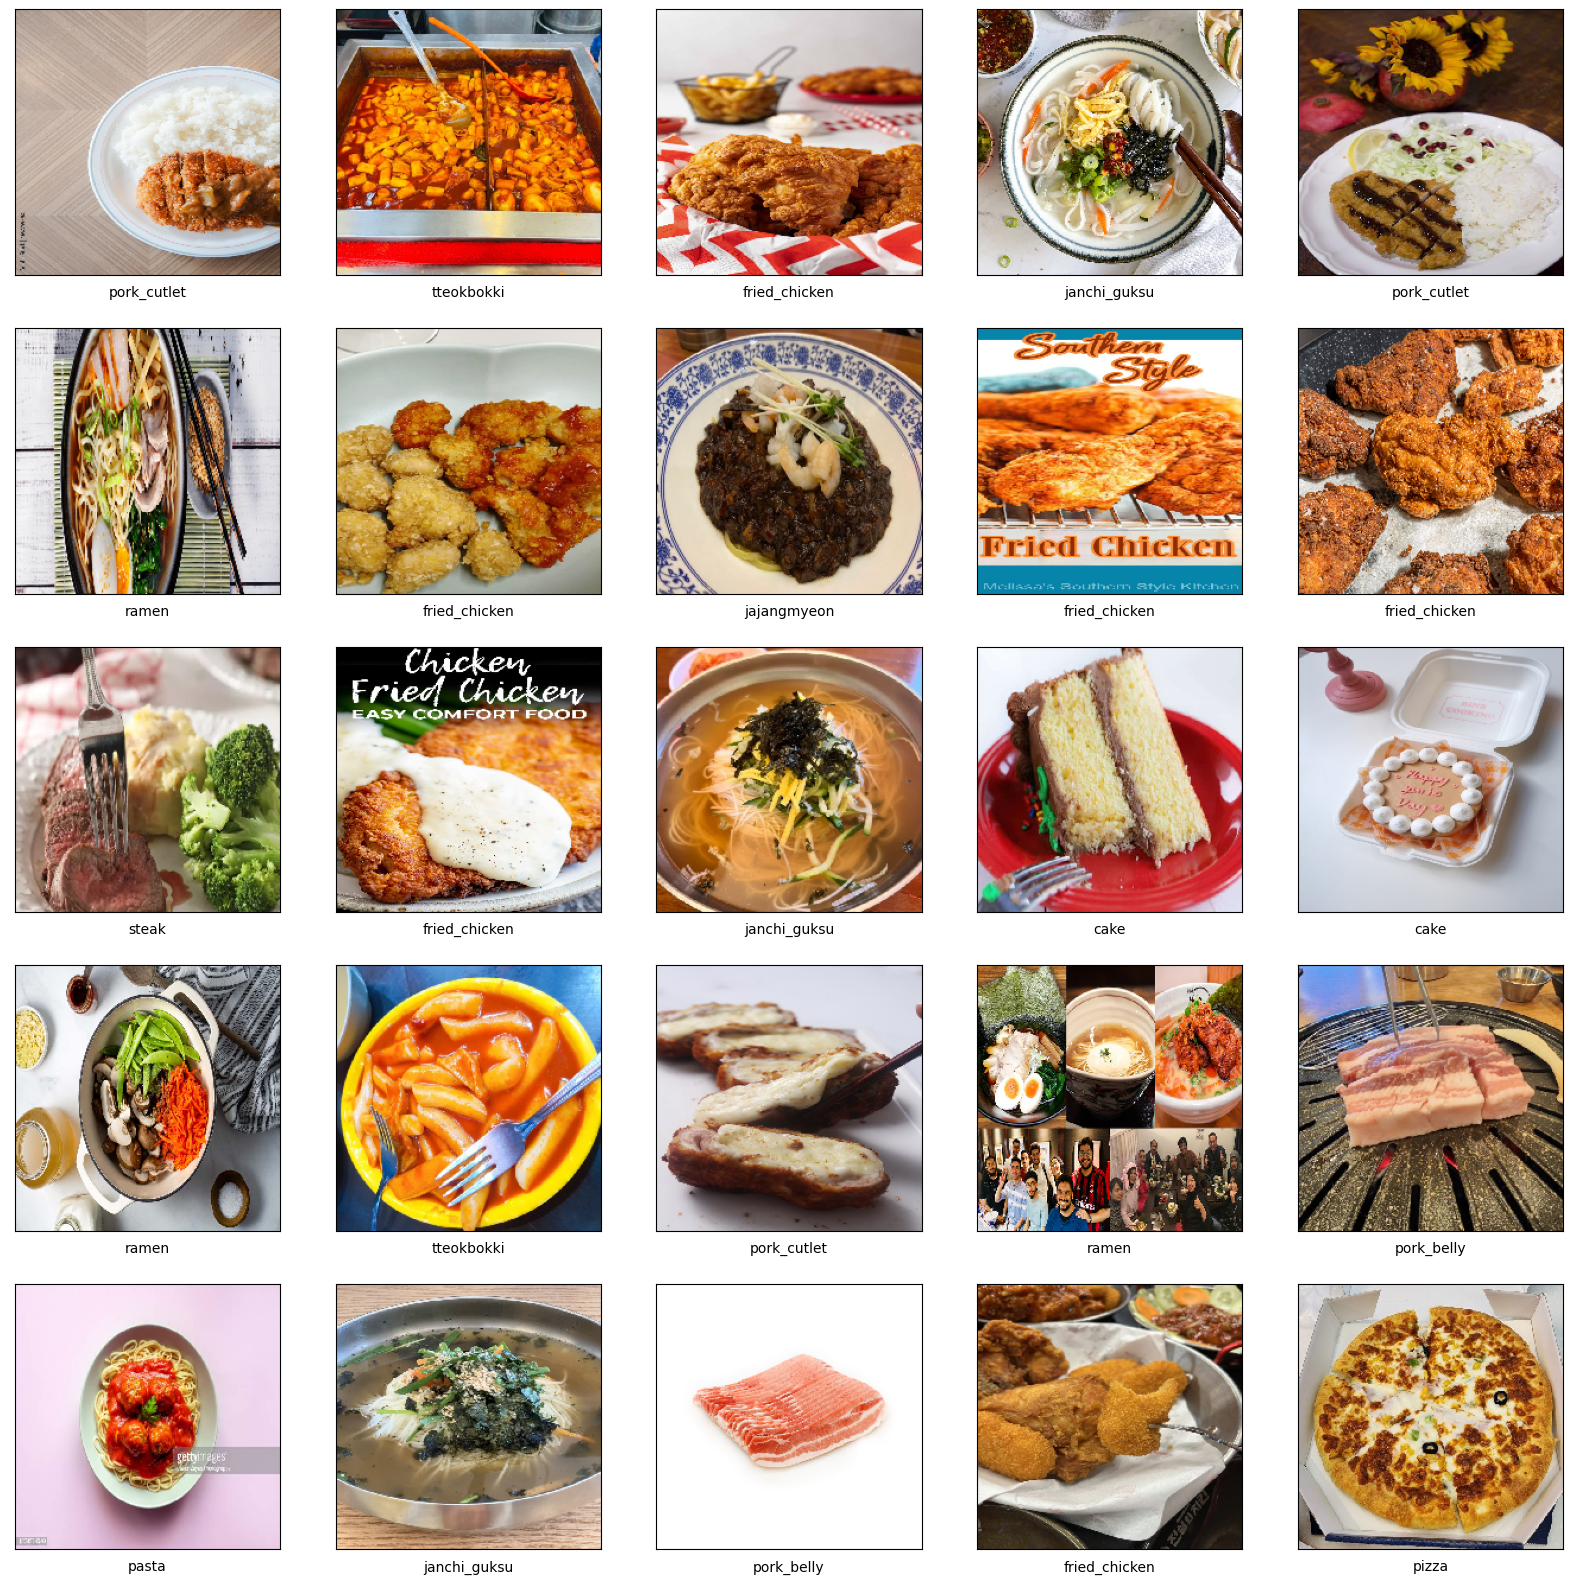

In [4]:
# 이미지 시각화

plt.figure(figsize=(20, 20))
index = np.random.randint(len(train_df), size=25)
for i in range(25):
    label = train_df['label'][index[i]]
    path_img = train_df['image'][index[i]]
    path_img = os.path.join(os.path.join(label, path_img))

    img = image.load_img(path_img, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()


In [5]:
cd ..

c:\Users\AI06\Desktop\DL


In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(
    train_df, test_size=0.1, stratify=train_df['label'])  # 라벨 비율 대로 데이터 분리
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)


In [7]:
def cls(x): return os.path.join(
    'train', '_'.join(x.split('_')[1:-1]) + '\\' + x)


train['image'] = train['image'].map(lambda x: cls(x))
train.head(10)

valid['image'] = valid['image'].map(lambda x: cls(x))
valid.head(10)

image          label
0                     train\cake\google_cake_47.jpg           cake
1  train\fried_chicken\google_fried_chicken_717.jpg  fried_chicken
2        train\tteokbokki\google_tteokbokki_191.jpg     tteokbokki
3    train\janchi_guksu\google_janchi_guksu_215.jpg   janchi_guksu
4                  train\steak\google_steak_255.jpg          steak
5                    train\cake\google_cake_686.jpg           cake
6        train\pork_belly\google_pork_belly_150.jpg     pork_belly
7      train\pork_cutlet\google_pork_cutlet_316.jpg    pork_cutlet
8          train\pork_belly\naver_pork_belly_24.jpg     pork_belly
9                  train\steak\google_steak_228.jpg          steak

In [8]:
cd DL

[WinError 2] 지정된 파일을 찾을 수 없습니다: 'DL'
c:\Users\AI06\Desktop\DL


In [9]:
train 

image         label
0                    train\pizza\google_pizza_453.jpg         pizza
1                     train\pizza\google_pizza_60.jpg         pizza
2                    train\pasta\google_pasta_868.jpg         pasta
3      train\janchi_guksu\google_janchi_guksu_221.jpg  janchi_guksu
4                     train\steak\naver_steak_470.jpg         steak
...                                               ...           ...
10183                train\steak\google_steak_160.jpg         steak
10184     train\grilled_eel\naver_grilled_eel_340.jpg   grilled_eel
10185                 train\ramen\naver_ramen_344.jpg         ramen
10186                 train\ramen\naver_ramen_131.jpg         ramen
10187    train\grilled_eel\google_grilled_eel_560.jpg   grilled_eel

[10188 rows x 2 columns]

In [10]:
# 데이터 증강 => 배치사이즈

height, width, channel = (224, 224, 3)
batch_size = 128
labels = train_df.label.unique().tolist()

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.2,
    rescale=1.0 / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=False,
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)


train_generator = train_datagen.flow_from_dataframe(train,
                                                    x_col='image',
                                                    y_col='label',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(height, width))


valid_generator = valid_datagen.flow_from_dataframe(valid,
                                                    x_col='image',
                                                    y_col='label',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(height, width))


Found 10188 validated image filenames belonging to 12 classes.
Found 1133 validated image filenames belonging to 12 classes.


In [11]:
from tensorflow.keras.applications import DenseNet121, ResNet152V2, Xception, EfficientNetB7
from tensorflow.keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [12]:
# Adds new top to base model
def build_top(base):
    x = base.output

    # Global averaging pool layer
    x = GlobalAveragePooling2D()(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    # Output layer
    outputs = Dense(len(labels), activation='softmax')(x)

    return Model(inputs=base.input, outputs=outputs)


# Sets up model for transfer learning
def setup_model(model, base):
    # 가중치 동결 
    for layer in base.layers:
        layer.trainable = False

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(0.0003),
        metrics=['accuracy']
    )


In [13]:
input_tensor = Input(shape=(224, 224, 3))
base_model = Xception(input_tensor=input_tensor,
                      include_top=False, weights='imagenet')

model = build_top(base_model)
setup_model(model, base_model)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [15]:
# 조기멈춤
stop = EarlyStopping(patience=5)

# 자동 저장
checkpoint = ModelCheckpoint("layer_best_model/model_weights", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1, save_best_only=True)

callbacks = [stop, checkpoint]

In [16]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=100, callbacks=callbacks)

Epoch 1/100
 3/80 [>.............................] - ETA: 1:15 - loss: 2.5386 - accuracy: 0.1120

c:\Users\AI06\anaconda3\envs\ml\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


80/80 [==============================] - ETA: 0s - loss: 1.5796 - accuracy: 0.4894
Epoch 1: val_accuracy improved from -inf to 0.76523, saving model to layer_best_model\model_weights
80/80 [==============================] - 144s 2s/step - loss: 1.5796 - accuracy: 0.4894 - val_loss: 0.7859 - val_accuracy: 0.7652
Epoch 2/100
80/80 [==============================] - ETA: 0s - loss: 0.9972 - accuracy: 0.6843
Epoch 2: val_accuracy improved from 0.76523 to 0.79170, saving model to layer_best_model\model_weights
80/80 [==============================] - 141s 2s/step - loss: 0.9972 - accuracy: 0.6843 - val_loss: 0.6475 - val_accuracy: 0.7917
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.7268
Epoch 3: val_accuracy improved from 0.79170 to 0.79876, saving model to layer_best_model\model_weights
80/80 [==============================] - 140s 2s/step - loss: 0.8655 - accuracy: 0.7268 - val_loss: 0.6055 - val_accuracy: 0.7988
Epoch 4/100
80/80 [============

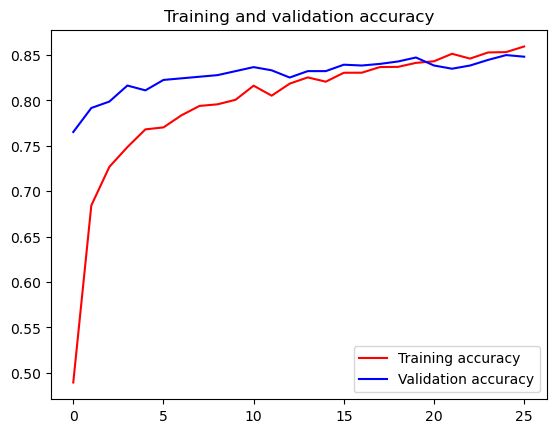

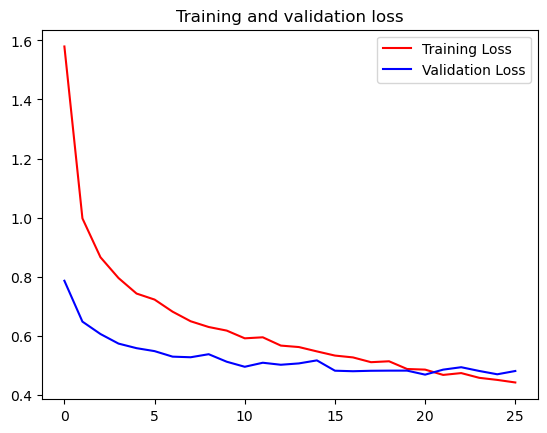

In [17]:
# 학습 곡선 확인

def plot_history():
    plt.plot(history.history['accuracy'], 'r', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(history.history['loss'], 'r', label='Training Loss')
    plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_history()


In [18]:

# fine_tuning
def setup_model(model, train_layer):
    # Freeze the un-trainable layers of the model base
    for layer in model.layers[:(len(model.layers) - train_layer)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - train_layer):]:
        layer.trainable = True

    model.compile(
        loss='categorical_crossentropy',
        # 학습률을 더 작게 설정함 
        optimizer=Adam(0.00001),
        metrics=['accuracy']
    )


# Setup model to retrain our top layer plus block 13 and 14 of Xception
setup_model(model, 19)


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [20]:
# Fine-tune the model
model.fit_generator(
    train_generator,
    epochs=200,
    validation_data=valid_generator,
    callbacks=callbacks
)


C:\Users\AI06\AppData\Local\Temp\ipykernel_23180\1540792717.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/200
80/80 [==============================] - ETA: 0s - loss: 0.7609 - accuracy: 0.7870
Epoch 1: val_accuracy did not improve from 0.84996
80/80 [==============================] - 141s 2s/step - loss: 0.7609 - accuracy: 0.7870 - val_loss: 0.5075 - val_accuracy: 0.8358
Epoch 2/200
80/80 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.8254
Epoch 2: val_accuracy did not improve from 0.84996
80/80 [==============================] - 138s 2s/step - loss: 0.5830 - accuracy: 0.8254 - val_loss: 0.4979 - val_accuracy: 0.8491
Epoch 3/200
80/80 [==============================] - ETA: 0s - loss: 0.5211 - accuracy: 0.8392
Epoch 3: val_accuracy improved from 0.84996 to 0.86231, saving model to layer_best_model\model_weights
80/80 [==============================] - 139s 2s/step - loss: 0.5211 - accuracy: 0.8392 - val_loss: 0.4687 - val_accuracy: 0.8623
Epoch 4/200
80/80 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.8461
Epoch 4: val_accuracy imp

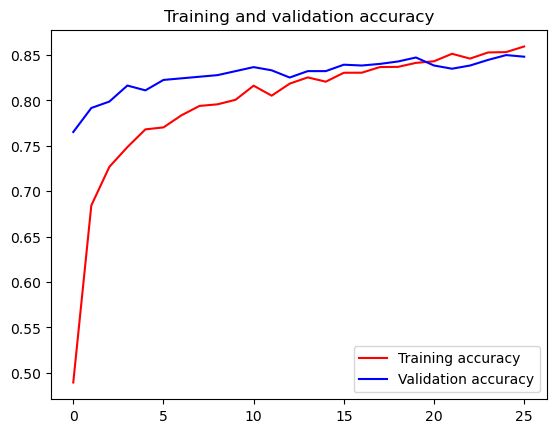

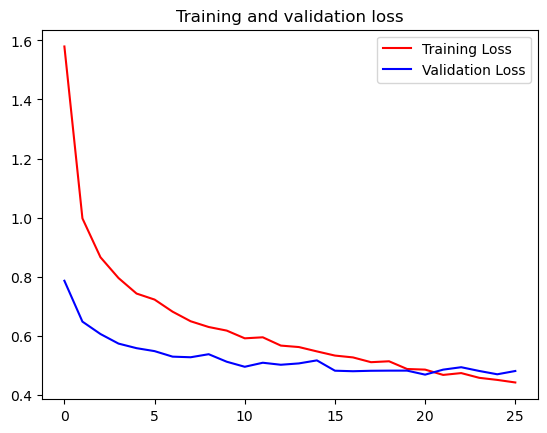

In [21]:
plot_history()

### test set으로 예측 

In [22]:
test_df = pd.read_csv("submission.csv")
test_df.head(5)


batch_size = len(test_df["image"])
height, width, channel = 224, 224, 3

path = os.path.join('test')

test_image = np.zeros((batch_size, height, width, channel))
print(test_image.shape)

cnt = 0


(2766, 224, 224, 3)


In [23]:
for i in range(len(test_df["image"])):
    path_img = test_df['image'][i]
    img = image.load_img(os.path.join(path, path_img),
                         target_size=(height, width))
    img_tensor = image.img_to_array(img)
    img_tensor = np.array(img_tensor, dtype="float32")

    img_tensor /= 255

    img_tensor = np.expand_dims(img_tensor, axis=0)

    test_image[i] = img_tensor

    if (i % 200 == 0):
        print(str(i) + " 완료")  # 진행 상황 확인용


0 완료


c:\Users\AI06\anaconda3\envs\ml\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200 완료
400 완료
600 완료
800 완료
1000 완료
1200 완료
1400 완료
1600 완료
1800 완료
2000 완료
2200 완료
2400 완료
2600 완료


In [24]:
# 라벨맵 
pred2label = {}
for x in train_generator.class_indices.keys():
    pred2label[train_generator.class_indices[x]] = x

In [25]:
predictions = model.predict(test_image)


test_df['label'] = [pred2label[np.argmax(pred)] for pred in predictions]

print(test_df)

test_df.to_csv('Xception_layer_tuned.csv', index=False)


87/87 [==============================] - 7s 69ms/step
              image          label
0     test_1553.jpg     pork_belly
1     test_2202.jpg          ramen
2     test_1556.jpg    pork_cutlet
3      test_660.jpg          pizza
4      test_677.jpg          ramen
...             ...            ...
2761  test_2189.jpg          pasta
2762   test_223.jpg  fried_chicken
2763   test_303.jpg   janchi_guksu
2764  test_1681.jpg   janchi_guksu
2765   test_777.jpg           cake

[2766 rows x 2 columns]
